In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
# suppress warnings
warnings.filterwarnings('ignore')
import os
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, Birch, OPTICS, MeanShift, AgglomerativeClustering
import time
from sklearn.model_selection import ParameterSampler
from typing import Union, Tuple
from os import PathLike
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn import metrics
import ast
import matplotlib.pyplot as plt

n_iter = 20000
MAJOR_MINOR_VERSION = '1.5'
from sklearn.model_selection import KFold

n_splits = 3  # Number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

ALGORITHM_NAME = "DBSCAN"

In [2]:

def map_clusters_to_ground_truth_dbscan(labels_true, labels_pred):
    """
    Adjusted mapping for DBSCAN output to ground truth labels, excluding noise points.
    """
    # Ensure labels_true and labels_pred are numpy arrays for advanced indexing
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)

    # Filter out noise points (-1 labels) from labels_pred for mapping
    valid_idx = labels_pred != -1
    labels_pred_filtered = labels_pred[valid_idx]
    labels_true_filtered = labels_true[valid_idx]

    # Calculate the confusion matrix without noise points
    cm = confusion_matrix(labels_true_filtered, labels_pred_filtered)
    # Apply the Hungarian algorithm for optimal matching
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Initialize remapped labels array with -1 for noise points
    remapped_labels_pred = -1 * np.ones_like(labels_pred)
    # Map valid clusters excluding noise
    for original, new in zip(col_ind, row_ind):
        # Find indices in the filtered prediction that match the original cluster
        indices = np.where(labels_pred_filtered == original)[0]
        # For each of these indices, update the corresponding entry in the full remapped prediction array
        for idx in indices:
            # Convert filtered index back to original index
            original_idx = np.where(valid_idx)[0][idx]
            remapped_labels_pred[original_idx] = new

    return remapped_labels_pred

def evaluate_clustering(X, labels_true, labels_pred, clus_algo_name, dataset_name, results_path, algorithm_details,
                        training_time, prediction_time):
    """
    Evaluates the clustering performance using various metrics and saves the results to a CSV file.

    :param X: Feature set.
    :param labels_true: Ground truth labels.
    :param labels_pred: Predicted cluster labels.
    :param clus_algo_name: Name of the clustering algorithm.
    :param dataset_name: Name of the dataset.
    :param results_path: Path to save the results CSV file.
    """
    # Ensure there are at least 2 unique labels before calculating certain metrics
    unique_labels = np.unique(labels_pred)

    # Initialize default values for scores that require multiple clusters
    calinski_harabasz_score = np.nan
    davies_bouldin_score = np.nan
    silhouette_score = np.nan

    if len(unique_labels) > 1:
        calinski_harabasz_score = metrics.calinski_harabasz_score(X, labels_pred)
        davies_bouldin_score = metrics.davies_bouldin_score(X, labels_pred)
        silhouette_score = metrics.silhouette_score(X, labels_pred)

    results = {
        'Timestamp': datetime.now(),
        'Dataset': dataset_name,
        'Clustering Algorithm': clus_algo_name,
        'Algorithm Details': algorithm_details,
        'Training Time': training_time,
        'Prediction Time': prediction_time,
        'AMI': metrics.adjusted_mutual_info_score(labels_true, labels_pred),
        'ARI': metrics.adjusted_rand_score(labels_true, labels_pred),
        'Calinski-Harabasz Score': calinski_harabasz_score,
        'Davies-Bouldin Score': davies_bouldin_score,
        'Completeness Score': metrics.completeness_score(labels_true, labels_pred),
        'Fowlkes-Mallows Score': metrics.fowlkes_mallows_score(labels_true, labels_pred),
        'Homogeneity': metrics.homogeneity_score(labels_true, labels_pred),
        'Completeness': metrics.completeness_score(labels_true, labels_pred),
        'V-Measure': metrics.v_measure_score(labels_true, labels_pred),
        'Mutual Information': metrics.mutual_info_score(labels_true, labels_pred),
        'Normalized Mutual Information': metrics.normalized_mutual_info_score(labels_true, labels_pred),
        'Silhouette Score': silhouette_score,
        'Accuracy': accuracy_score(labels_true, labels_pred)

    }

    # # Print results
    # for key, value in results.items():
    #     if key == 'Confusion Matrix':
    #         print(f"{key}:\n{value}")
    #     else:
    #         print(f"{key}: {value}")

    # Save to CSV
    df = pd.DataFrame([results])
    df.to_csv(results_path, mode='a', header=not os.path.exists(results_path), index=False)


def map_clusters_to_ground_truth(labels_true, labels_pred):
    """
    Maps clustering algorithm output to ground truth labels using the Hungarian algorithm.

    :param labels_true: Ground truth labels.
    :param labels_pred: Predicted cluster labels.
    :return: Remapped predicted labels.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(labels_true, labels_pred)
    # Apply the Hungarian algorithm to the negative confusion matrix for maximum matching
    row_ind, col_ind = linear_sum_assignment(-cm)

    # Create a new array to hold the remapped predicted labels
    remapped_labels_pred = np.zeros_like(labels_pred)
    # For each original cluster index, find the new label (according to the Hungarian algorithm)
    # and assign it in the remapped labels array
    for original_cluster, new_label in zip(col_ind, row_ind):
        remapped_labels_pred[labels_pred == original_cluster] = new_label

    return remapped_labels_pred


def load_labels_from_file(file_path):
    """
    Loads clustering labels from a text file, ignoring the header and metadata.

    :param file_path: Path to the file containing the labels.
    :return: List of labels as integers.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Skipping the header and metadata, start reading from the line after '-----'
    start_index = lines.index('-------------------------------------\n') + 1
    labels_true = [int(line.strip()) for line in lines[start_index:]]
    return labels_true


def preprocess_data(df):
    """
    Function to preprocess data by normalizing it.

    :param df: pandas DataFrame with raw data.
    :return: pandas DataFrame with processed (normalized) data.
    """
    processed_df = df.copy()

    # Normalize the data
    # For each column, subtract the minimum and divide by the range.
    for column in processed_df.columns:
        min_value = processed_df[column].min()
        max_value = processed_df[column].max()
        processed_df[column] = (processed_df[column] - min_value) / (max_value - min_value)

    return processed_df


def find_next_version_number(base_path: str, algorithm_name: str, major_minor_version: str) -> str:
    """
    Finds the next version number based on existing directories within the algorithm name directory.
    Args:
    - base_path: The base directory path where algorithms are stored.
    - algorithm_name: The name of the algorithm.
    - major_minor_version: The major and minor version components (e.g., '1.0').

    Returns:
    - The next version as a string (e.g., '1.0.3').
    """
    algorithm_path = os.path.join(base_path, algorithm_name)
    if not os.path.exists(algorithm_path):
        return major_minor_version + '.1'  # Start with version .1 if no directory exists

    # List all version directories and filter by the major_minor_version prefix
    version_dirs = [d for d in os.listdir(algorithm_path) if os.path.isdir(os.path.join(algorithm_path, d))]
    version_nums = [d.replace(major_minor_version + '.', '') for d in version_dirs if d.startswith(major_minor_version)]

    if not version_nums:
        return major_minor_version + '.1'  # Start with version .1 if no matching directories

    # Find the highest current version number
    latest_version = max([int(num) for num in version_nums if num.isdigit()], default=0)

    # Return the next version number
    return major_minor_version + '.' + str(latest_version + 1)


# Function to create directories and return the path for results
def create_dirs_and_get_results_path(base_path: Union[str, PathLike],
                                     algorithm_name: str,
                                     version: str,
                                     dataset_dir: str,
                                     dataset_name: str,
                                     filename: str) -> str:
    directory_path = os.path.join(base_path, algorithm_name, version, dataset_dir, dataset_name)
    os.makedirs(directory_path, exist_ok=True)
    return os.path.join(directory_path, filename)


def calculate_grid_size(space):
    # For each parameter, count the number of unique values and multiply them
    return np.prod([len(values) for values in space.values()])


# Functions
def train_and_time(clustering_model, train_data):
    """Train the model and measure training time."""
    start_time = time.time()
    clustering_model.fit(train_data)
    end_time = time.time()
    return clustering_model, end_time - start_time


def predict_and_time(clustering_model, data):
    """Predict using the model and measure prediction time."""
    start_time = time.time()
    if ALGORITHM_NAME == 'DBSCAN' or ALGORITHM_NAME == 'OPTICS' or ALGORITHM_NAME == 'AgglomerativeClustering':
        labels_pred = clustering_model.fit_predict(data)
    else:
        labels_pred = clustering_model.predict(data)
    end_time = time.time()
    return labels_pred, end_time - start_time


def evaluate_and_log(clustering_model, X_train, X_validate, labels_true, results_path):
    """Evaluate the clustering and log the results."""
    algorithm_details = str(clustering_model.get_params())
    _, training_time = train_and_time(clustering_model, X_train)
    labels_pred, prediction_time = predict_and_time(clustering_model, X_validate)
    labels_pred = map_clusters_to_ground_truth(labels_true, labels_pred)
    evaluate_clustering(X=X_validate, labels_true=labels_true, labels_pred=labels_pred,
                        clus_algo_name=ALGORITHM_NAME, dataset_name="debug",
                        results_path=results_path, algorithm_details=algorithm_details,
                        training_time=training_time, prediction_time=prediction_time)



# prepare data

In [3]:
raw_directory_path = "./clustering_dataset/raw/A-sets"
processed_directory_path = "./clustering_dataset/processed/A-sets"

# Get a list of all files in the directory (excluding directories)
files = [f for f in os.listdir(raw_directory_path) if os.path.isfile(os.path.join(raw_directory_path, f))]
total_files = len(files)
print(total_files)

3


In [4]:
# Run preprocessing step for all files in the specified directory
for index, filename in enumerate(files, start=1):
    FILE_NAME = filename.split('.')[0]
    raw_file_path = os.path.join(raw_directory_path, f'{FILE_NAME}.txt')
    processed_file_path = os.path.join(processed_directory_path, f'{FILE_NAME}.txt')

    # Check if the processed file already exists
    if not os.path.isfile(processed_file_path):
        # The regular expression '\s+' can be used to match one or more spaces
        data = pd.read_csv(raw_file_path, sep="\s+", header=None, names=['X', 'Y'])
        # Remove rows with missing values:
        processed_data = preprocess_data(data)

        # Save the processed data to a CSV file
        processed_data.to_csv(processed_file_path, index=False)

# Perform clustering

In [5]:
files

['a1.txt', 'a2.txt', 'a3.txt']

In [6]:
# index = 1
# filename = files[index - 1]
raw_file_path = "./clustering_dataset/raw/A-sets/a2.txt"
labels_true = load_labels_from_file("./clustering_dataset/label/A-sets/a2-gt.pa")
N_CLUSTERS = len(set(labels_true))
raw_data = pd.read_csv(raw_file_path, sep='\s+')
N_DIMENSIONS = raw_data.shape[1]

eps_exponents = np.random.uniform(-5, 2, 20000)
eps_values = 10 ** eps_exponents

hyperparameter_domains = {
    'DBSCAN': {
        'eps': eps_values,
        'min_samples': [N_DIMENSIONS, N_DIMENSIONS + 1 ]
    }
}

processed_data = pd.read_csv("./clustering_dataset/processed/A-sets/a2.txt")
hyperparameter_domain = hyperparameter_domains["DBSCAN"]
grid_size = calculate_grid_size(hyperparameter_domain)
tuning_results_filename = 'hyperparameter_tuning_logs.csv'
tuning_results_path = "debug/tuning_results_path/debug.csv"
final_results_path = "debug/final_results_path"


parameter_sampler = ParameterSampler(hyperparameter_domain, n_iter=n_iter, random_state=42)

# for fold, (train_index, test_index) in enumerate(kf.split(processed_data, labels_true)):
#     X_train, X_test = processed_data.iloc[train_index], processed_data.iloc[test_index]
#     y_train, y_test = pd.Series(labels_true)[train_index], pd.Series(labels_true)[test_index]

#     # for params in parameter_sampler:
#     # model = DBSCAN(**params)
#     model = DBSCAN()

#     model.fit(X_train)    
#     labels_pred = model.fit_predict(X_test) 
#     labels_pred = map_clusters_to_ground_truth(y_test, labels_pred)
    
#     acc = accuracy_score(y_test, labels_pred)
#     print(acc)
#     break  

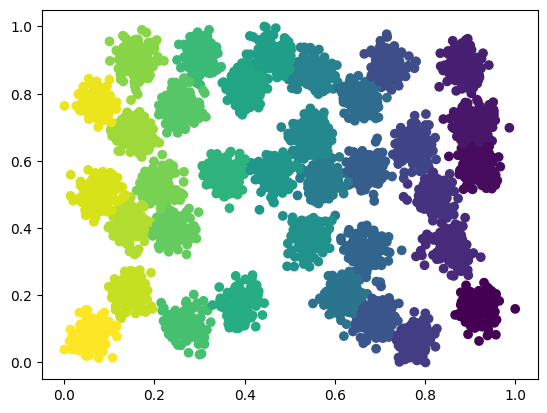

In [7]:
plt.scatter(processed_data["X"], processed_data["Y"], c=labels_true)

In [8]:

best_eps = 0
best_min_samples = 0
max_acc = 0

for eps in np.linspace(0.01, 0.2, 30):
    for min_samples in range(3, 50):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels_pred = model.fit_predict(processed_data)    
        labels_pred = map_clusters_to_ground_truth_dbscan(labels_true, labels_pred)
        
        acc = accuracy_score(labels_true, labels_pred)
        if acc > max_acc:
            max_acc = acc
            best_eps = eps
            best_min_samples = min_samples
            print(max_acc)
        
print(max_acc, best_eps, best_min_samples)    
# acc = accuracy_score(labels_true, labels_pred)
# print(acc)

model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
labels_pred = model.fit_predict(processed_data)
labels_pred = map_clusters_to_ground_truth_dbscan(labels_true, labels_pred)


0.7436190476190476
0.7954285714285714
0.8323809523809523
0.832952380952381
0.8464761904761905
0.847047619047619
0.8582857142857143
0.8805714285714286
0.8859047619047619
0.8859047619047619 0.029655172413793104 45


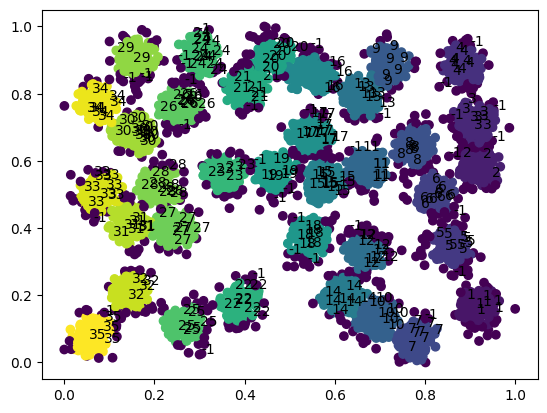

In [9]:
plt.scatter(processed_data["X"], processed_data["Y"], c=labels_pred)

# annotate randomly 0.1
for i, txt in enumerate(labels_pred):
    # plt.annotate(txt, (processed_data["X"][i], processed_data["Y"][i]))
    if np.random.rand() < 0.05:
        plt.annotate(txt, (processed_data["X"][i], processed_data["Y"][i]))


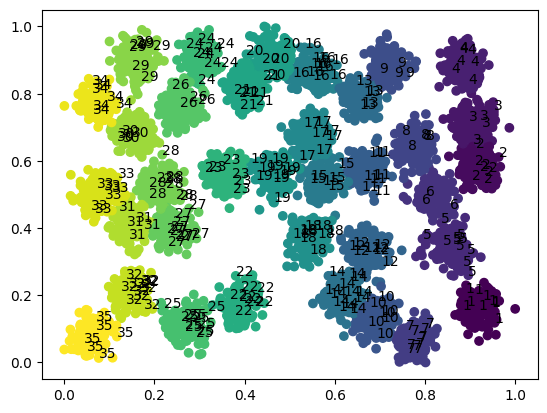

In [10]:
plt.scatter(processed_data["X"], processed_data["Y"], c=labels_true)

# annotate randomly 0.1
for i, txt in enumerate(labels_true):
    # plt.annotate(txt, (processed_data["X"][i], processed_data["Y"][i]))
    if np.random.rand() < 0.05:
        plt.annotate(txt, (processed_data["X"][i], processed_data["Y"][i]))
